<h1>개인 구글 드라이브와 colab 연동</h1>

In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [2]:
!pip install transformers
!pip install sentencepiece

root_dir = "/gdrive/My Drive/NLP/week3/4-2. Pretrained LM1"

import sys
sys.path.append(root_dir)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


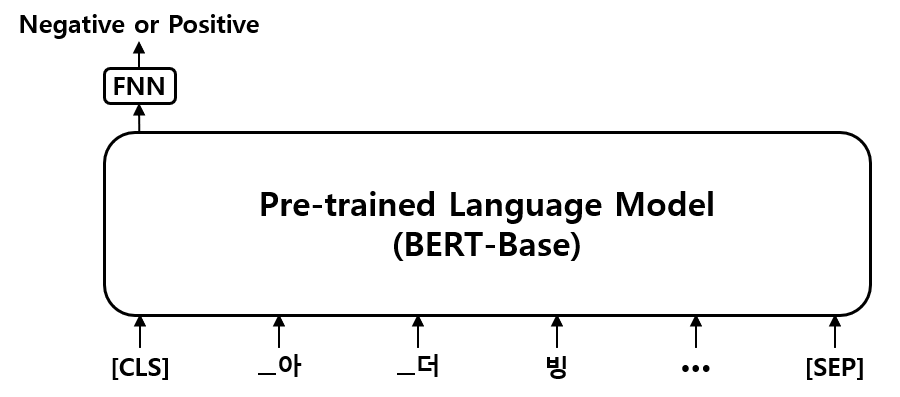

In [3]:
import os
from IPython.display import Image
Image(os.path.join(root_dir, "BERT.png"))

<h1>BERT 모델을 이용한 감성분류</h1>

In [4]:
import torch.nn as nn
from transformers import BertPreTrainedModel, BertModel #transformer 패키지 안에 BERT 모델 가져옴


class SentimentClassifier(BertPreTrainedModel): # BertPreTrainedModel 상속받음

  # 2개의 메소드
    def __init__(self, config): # 생성자
        super(SentimentClassifier, self).__init__(config) # Bert 사전학습 모델 생상자 오버라이딩

        # BERT 모델
        self.bert = BertModel(config) 

        # 히든 사이즈 - Bert의 출력사이즈가 hidden size
        self.hidden_size = config.hidden_size

        

        # 분류할 라벨의 개수
        self.num_labels = config.num_labels

        self.linear = nn.Linear(in_features=self.hidden_size, out_features=self.num_labels)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None): 
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask,
                            token_type_ids=token_type_ids) # 숫자로 받아야 함

        # BERT 출력에서 CLS에 대응하는 벡터 표현 추출
        # 선형 함수를 사용하여 예측 확률 분포로 변환

        ############코드 작성 부분###############
        # (batch_size, max_length, hidden_size) -> output, max_length는 문장의 최대 길이
        bert_output = outputs[0]

        # (batch_size, hidden_size)
        cls_vector = bert_output[:, 0, :] # 10개 입력이 들어가면 batch size만큼 나옴

        # class_output : (batch_size, num_labels)
        cls_output = self.linear(cls_vector)
        #########################################

        return cls_output

<h1>데이터 읽고 전처리 하기</h1>

<pre>
<b>1. read_data(file_path)</b>
  "train_datas_wordpiece.txt", "test_datas_wordpiece.txt" 파일을 읽기 위한 함수
  
  데이터 예시)
    ▁아 ▁더 빙 . . ▁진짜 ▁짜 증 나 네요 ▁목소리 \t negative
  
  read_file(file_path)
  args
    file_path : 읽고자 하는 데이터의 경로
  return
    datas : 영화 리뷰, 정답 라벨
    
    출력 예시)
      datas = [
        (['▁아', '▁더', '빙', '.', '.', '▁진짜', '▁짜', '증', '나', '네요', '▁목소리'], negative)

        (...),
        
        ]
      
<b>2. read_vocab_data(vocab_data_path)</b>
  "label_vocab.txt" 파일을 읽고 라벨을 indexing하기 위한 딕셔너리를 생성
   
  read_vocab_data(vocab_data_path)
  args
    vocab_data_path : 어휘 파일 경로
  return  
    term2idx : 라벨을 대응하는 index로 치환하기 위한 딕셔너리
    idx2term : index를 대응하는 라벨로 치환하기 위한 딕셔너리

<b>3. convert_data2feature(datas, max_length, tokenizer, label2idx)</b>
  입력 데이터를 고정된 길이로 변환 후 indexing
  Tensor로 변환
   
  convert_data2feature(datas, max_length, tokenizer, label2idx)
  args
    datas : 영화 리뷰 데이터와 대응하는 정답 라벨을 갖고 있는 리스트
    max_length : 입력의 최대 길이
    tokenizer : electra tokenizer 객체
    label2idx : 라벨을 대응하는 index로 치환하기 위한 딕셔너리
  return
    input_ids_features : 입력 문장에 대한 index sequence
    label_id_features : 정답을 갖고 있는 리스트
    
  전처리 예시)
    tokenizing된 리뷰 데이터['▁아', '▁더', '빙', '.', '.', '▁진짜', '▁짜', '증', '나', '네요', '▁목소리', ...]
    input_ids : [2, 3360, 28709, 18, 18, 12704, 29334, ... ]
    label_id : [1]
 </pre>


In [5]:
import torch

# 데이터 읽기
def read_data(file_path):
    with open(file_path, "r", encoding="utf8") as inFile: #[[...], [...], ...]
        lines = inFile.readlines()

    datas = []
    for line in lines:
        # 입력 데이터를 \t을 기준으로 분리
        pieces = line.strip().split("\t")

        # 리뷰, 정답
        input_sequence, label = pieces[0].split(" "), pieces[1]

        datas.append((input_sequence, label))

    return datas

# 사전 읽기
def read_vocab_data(vocab_data_path):
    term2idx, idx2term = {}, {}

    with open(vocab_data_path, "r", encoding="utf8") as inFile:
        lines = inFile.readlines()

    for line in lines:
        term = line.strip()
        term2idx[term] = len(term2idx)
        idx2term[term2idx[term]] = term

    return term2idx, idx2term

# 데이터 전처리 
def convert_data2feature(datas, max_length, tokenizer, label2idx): # tokenizer는 언어 모델에 포함된 객체
    input_ids_features, label_id_features = [], []

    for input_sequence, label in datas:

        # CLS, SEP 토큰 추가
        tokens = [tokenizer.cls_token] # cls_token : cls 를 붙임
        tokens += input_sequence
        tokens = tokens[:max_length - 1] # 정해진 max length 보다 길면 삭제 (보통 512)
        tokens += [tokenizer.sep_token] # sep_token : sep 를 붙임

        # word piece들을 대응하는 index로 치환
        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # padding 생성
        padding = [tokenizer._convert_token_to_id(tokenizer.pad_token)] * (max_length - len(input_ids)) # 90개를 padding으로 채움움
        input_ids += padding

        label_id = label2idx[label]

        # 변환한 데이터를 각 리스트에 저장
        input_ids_features.append(input_ids)
        label_id_features.append(label_id)

    # 변환한 데이터를 Tensor 객체에 담아 반환
    input_ids_features = torch.tensor(input_ids_features, dtype=torch.long)
    label_id_features = torch.tensor(label_id_features, dtype=torch.long)

    return input_ids_features, label_id_features

<h1>BERT 모델 학습</h1>

<pre>
<b>1. read_data(file_path) 함수를 사용하여 학습 데이터 읽기</b>

<b>2. read_vocab_data(vocab_data_path) 함수를 사용하여 어휘 딕셔너리 생성</b>

<b>3. convert_data2feature(datas, max_length, tokenizer, label2idx) 함수를 사용하여 데이터 전처리</b>

<b>4. BERT 모델 객체 선언 후 사전 학습 파일 불러옴</b>

<b>5. epoch 마다 학습한 모델 파일 저장</b>
</pre>

In [6]:
import torch
from torch.utils.data import (DataLoader, TensorDataset, RandomSampler)
import torch.optim as optim
import numpy as np

from transformers import BertConfig
from tokenization_kobert import KoBertTokenizer

# Train
def train(config):
    # BERT config 객체 생성
    bert_config = BertConfig.from_pretrained(pretrained_model_name_or_path=config["pretrained_model_name_or_path"],
                                             cache_dir=config["cache_dir_path"])
    setattr(bert_config, "num_labels", config["num_labels"]) # 기존 BERT config에 프로그램에서 새로 정의한 config 추가가

    # BERT tokenizer 객체 생성
    bert_tokenizer = KoBertTokenizer.from_pretrained(pretrained_model_name_or_path=config["pretrained_model_name_or_path"],
                                                     cache_dir=config["cache_dir_path"]) # KoBertTokenizer

    # 라벨 딕셔너리 생성
    label2idx, idx2label = read_vocab_data(vocab_data_path=config["label_vocab_data_path"])

    # 학습 및 평가 데이터 읽기
    train_datas = read_data(file_path=config["train_data_path"])

    # 입력 데이터 전처리
    train_input_ids_features, train_label_id_features = convert_data2feature(datas=train_datas,
                                                                             max_length=config["max_length"],
                                                                             tokenizer=bert_tokenizer,
                                                                             label2idx=label2idx)

    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    # batch size만큼 랜덤 샘플링
    train_dataset = TensorDataset(train_input_ids_features, train_label_id_features)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=config["batch_size"],
                                  sampler=RandomSampler(train_dataset))

    # 사전 학습된 BERT 모델 파일로부터 가중치 불러옴
    model = SentimentClassifier.from_pretrained(pretrained_model_name_or_path=config["pretrained_model_name_or_path"],
                                                cache_dir=config["cache_dir_path"], config=bert_config).cuda()

    # loss를 계산하기 위한 함수
    loss_func = nn.CrossEntropyLoss()

    # 모델 학습을 위한 optimizer
    optimizer = optim.Adam(model.parameters(), lr=2e-5)

    for epoch in range(config["epoch"]): # 한번 전체를 학습하는데 1 epoch
        model.train()

        total_loss = []
        for batch in train_dataloader: # dataloader에서 batch size만큼 가져옴
            batch = tuple(t.cuda() for t in batch)
            input_ids, label_id = batch

            # 역전파 단계를 실행하기 전에 변화도를 0으로 변경
            optimizer.zero_grad()

            # 모델 예측 결과
            hypothesis = model(input_ids) # Batch size만큼 2개씩 있음

            # loss 계산
            loss = loss_func(hypothesis, label_id)

            # loss 값으로부터 모델 내부 각 매개변수에 대하여 gradient 계산
            loss.backward()
            # 모델 내부 각 매개변수 가중치 갱신
            optimizer.step()

            # batch 단위 loss 값 저장
            total_loss.append(loss.data.item())

        bert_config.save_pretrained(save_directory=config["output_dir_path"])
        model.save_pretrained(save_directory=config["output_dir_path"])

        print("Average loss : {}".format(np.mean(total_loss)))

<h1>BERT 모델 평가</h1>

<pre>
<b>1. read_data(file_path) 함수를 사용하여 평가 데이터 읽기</b>

<b>2. read_vocab_data(vocab_data_path) 함수를 사용하여 어휘 딕셔너리 생성</b>

<b>3. convert_data2feature(datas, max_length, tokenizer, label2idx) 함수를 사용하여 데이터 전처리</b>

<b>4. BERT 모델 객체 선언 후 기존에 학습한 모델 파일 불러옴</b>

<b>5. 학습한 BERT 모델 평가</b>
</pre>

In [7]:
import torch
from torch.utils.data import (DataLoader, TensorDataset, SequentialSampler)

from transformers import BertConfig
from tokenization_kobert import KoBertTokenizer
from sklearn.metrics import accuracy_score

# Test
def test(config):
    # BERT config 객체 생성
    bert_config = BertConfig.from_pretrained(pretrained_model_name_or_path=config["output_dir_path"],
                                             cache_dir=config["cache_dir_path"])

    # BERT tokenizer 객체 생성 (기존 BERT tokenizer 그대로 사용)
    bert_tokenizer = KoBertTokenizer.from_pretrained(pretrained_model_name_or_path=config["pretrained_model_name_or_path"],
                                                     cache_dir=config["cache_dir_path"])

    # 라벨 딕셔너리 생성
    label2idx, idx2label = read_vocab_data(vocab_data_path=config["label_vocab_data_path"])

    # 평가 데이터 읽기
    test_datas = read_data(file_path=config["test_data_path"])
    test_datas = test_datas[:100]

    # 입력 데이터 전처리
    test_input_ids_features, test_label_id_features = convert_data2feature(datas=test_datas,
                                                                           max_length=config["max_length"],
                                                                           tokenizer=bert_tokenizer,
                                                                           label2idx=label2idx)

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_dataset = TensorDataset(test_input_ids_features, test_label_id_features)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=config["batch_size"],
                                 sampler=SequentialSampler(test_dataset))

    # 학습한 모델 파일로부터 가중치 불러옴
    model = SentimentClassifier.from_pretrained(pretrained_model_name_or_path=config["output_dir_path"],
                                                cache_dir=config["cache_dir_path"], config=bert_config).cuda()

    model.eval() # 평가모드

    for batch in test_dataloader:
        batch = tuple(t.cuda() for t in batch)
        input_ids, label_id = batch

        with torch.no_grad():
            # 모델 예측 결과
            hypothesis = model(input_ids)
            # 모델의 출력값에 softmax와 argmax 함수를 적용
            hypothesis = torch.argmax(torch.softmax(hypothesis, dim=-1), dim=-1)

        # Tensor를 리스트로 변경
        hypothesis = hypothesis.cpu().detach().numpy().tolist()
        label_id = label_id.cpu().detach().numpy().tolist()

        for index in range(len(input_ids)):
            input_tokens = bert_tokenizer.convert_ids_to_tokens(input_ids[index])
            input_sequence = bert_tokenizer.convert_tokens_to_string(input_tokens[1:input_tokens.index(bert_tokenizer.sep_token)])
            predict = idx2label[hypothesis[index]]
            correct = idx2label[label_id[index]]

            print("입력 : {}".format(input_sequence))
            print("출력 : {}, 정답 : {}\n".format(predict, correct))

    # 정확도 출력
    print("Accuracy : {}".format(accuracy_score(hypothesis, label_id)))

In [8]:
import os


if(__name__=="__main__"):
    root_dir = "/gdrive/My Drive/NLP/week3/4-2. Pretrained LM1"
    save_dir = os.path.join(root_dir, "save")
    output_dir = os.path.join(root_dir, "output")
    cache_dir = os.path.join(root_dir, "cache")
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)


    config = {"mode": "train",
              "train_data_path": os.path.join(root_dir, "train_datas_wordpiece.txt"),
              "test_data_path": os.path.join(root_dir, "test_datas_wordpiece.txt"),
              "output_dir_path": output_dir,
              "save_dir_path": save_dir,
              "cache_dir_path": cache_dir,
              "pretrained_model_name_or_path": "monologg/kobert",
              "label_vocab_data_path": os.path.join(root_dir, "label_vocab.txt"),
              "num_labels": 2,
              "max_length": 142,
              "epoch":10,
              "batch_size":64
              }

    if(config["mode"] == "train"):
        train(config)
    else:
        test(config)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.
Some weights of SentimentClassifier were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['linear.weight', 'linear.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Average loss : 0.5466813595051978
Average loss : 0.35647575196566855
Average loss : 0.25984031569426225
Average loss : 0.18614887337016453
Average loss : 0.12832394458211152
Average loss : 0.09586481693064332
Average loss : 0.07476156970758917
Average loss : 0.06418753172727718
Average loss : 0.049369262632243574
Average loss : 0.04125183761997777


In [9]:
if(__name__=="__main__"):
    root_dir = "/gdrive/My Drive/NLP/week3/4-2. Pretrained LM1"
    save_dir = os.path.join(root_dir, "save")
    output_dir = os.path.join(root_dir, "output")
    cache_dir = os.path.join(root_dir, "cache")
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)


    config = {"mode": "test",
              "train_data_path": os.path.join(root_dir, "train_datas_wordpiece.txt"),
              "test_data_path": os.path.join(root_dir, "test_datas_wordpiece.txt"),
              "output_dir_path": output_dir,
              "save_dir_path": save_dir,
              "cache_dir_path": cache_dir,
              "pretrained_model_name_or_path": "monologg/kobert",
              "label_vocab_data_path": os.path.join(root_dir, "label_vocab.txt"),
              "num_labels": 3,
              "max_length": 142,
              "epoch":10,
              "batch_size":64
              }

    if(config["mode"] == "train"):
        train(config)
    else:
        test(config)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


입력 : 굳 ᄏ
출력 : positive, 정답 : positive

입력 : GDNTOPCLASSINTHECLUB
출력 : positive, 정답 : negative

입력 : 뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아
출력 : positive, 정답 : negative

입력 : 지루하지는 않은데 완전 막장임... 돈주고 보기에는....
출력 : negative, 정답 : negative

입력 : 3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??
출력 : negative, 정답 : negative

입력 : 음악이 주가 된, 최고의 음악영화
출력 : positive, 정답 : positive

입력 : 진정한 쓰레기
출력 : negative, 정답 : negative

입력 : 마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다
출력 : negative, 정답 : negative

입력 : 갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한cg남무 아 그립다 동사서독같은 영화가 이건 3류아류작이다
출력 : negative, 정답 : negative

입력 : 이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..
출력 : positive, 정답 : positive

입력 : 괜찮네요오랜만포켓몬스터[UNK]밌어요
출력 : positive, 정답 : positive

입력 : 한국독립영화의 한계 그렇게 아버지가 된다와 비교됨
출력 : negative, 정답 : negative

입력 : 청춘은 아름답다 그 아름다움은 이성을 흔들어 놓는다. 찰나의 아름다움을 잘 포착한 섬세하고 아름다운 수채화같은 퀴어영화이다.
출력 : positive, 정답 : positive

입력 : 눈에 보이는 반전이었지만 영화의 흡인력은 사라지지 않았다.
출력 : positive, 정답 : positive

입력 : """스토리, 연출, 연

Accuracy : 0.8333333333333334 -> Accuarcy : 0.9444444444444444 으로 바뀌었다

BERT 모델 아키텍처 부분에서 outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask,
                            token_type_ids=token_type_ids)

● token_type_ids : 각 token이 어떤 문장에 속하는지를 나타내는 리스트이다. BERT는 한 번에 두문장(sentence A, sentence B)을 입력으로 받을 수 있는데, bert-based-uncased tokenizer는 sentence A에 속하는 token에는 0을, sentence B에 속하는 token에는 1을 부여

● attention_mask : attention 연산이 수행되어야 할 token과 무시해야 할 token을 구별하는 정보가 담긴 리스트. bert-base-uncased tokenizer는 attention 연산이 수행되어야 할, 일반적인 token에는 1을 부여하고, padding과 같이 attention 연산이 수행될 필요가 없는 token들에는 0을 부여한다.

